In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random as random
from scipy.stats import gaussian_kde

from mm_sbi_review.examples.misspec_ma1 import assumed_dgp, calculate_summary_statistics, true_dgp

In [2]:
np.random.seed(0)
key = random.PRNGKey(0)
num_sims = 1_000_000

# Generate random parameter values t1 in [-1, 1]
t1 = np.random.uniform(-1, 1, size=num_sims)

# Initialize an array to store summary statistics
ssx = np.zeros((num_sims, 2))

# Simulate data and calculate summary statistics
for i in range(num_sims):
    key, subkey = random.split(key)
    data = assumed_dgp(subkey, t1[i])  # assumed_dgp function should accept t1[i]
    ssx[i] = calculate_summary_statistics(data)

# Calculate summary statistics for true data
key, subkey = random.split(key)
ssy = calculate_summary_statistics(true_dgp(subkey))

# Compute Euclidean distances between ssx and ssy
distances = np.linalg.norm(ssx - ssy, axis=1)

# Find indices of the closest 10% and 1% simulations
num_eps10 = int(num_sims * 0.10)
num_eps01 = int(num_sims * 0.01)

sorted_indices = np.argsort(distances)
eps10_idx = sorted_indices[:num_eps10]
eps01_idx = sorted_indices[:num_eps01]

# Extract the corresponding summary statistics and t1 values
ssx_eps10 = ssx[eps10_idx]
t1_eps10 = t1[eps10_idx]

ssx_eps01 = ssx[eps01_idx]
t1_eps01 = t1[eps01_idx]


In [33]:
plt.rcParams.update({'font.size': 24})

# Define b_theta function
def b_theta(t):
    return np.array([1 + t ** 2, t])

# Generate values for b_theta
t_vals = np.linspace(-1, 1, 101)
b_theta_vals = np.array([b_theta(t) for t in t_vals])

# Plot the summary statistics
plt.figure(figsize=(8, 6))
plt.scatter(ssx[::1000, 1], ssx[::1000, 0], c='blue', alpha=0.1)
plt.scatter(ssx_eps10[::100, 1], ssx_eps10[::100, 0], c='red', alpha=0.5, label='Closest 10%')
plt.scatter(ssx_eps01[::10, 1], ssx_eps01[::10, 0], c='green', alpha=0.5, label='Closest 1%')
plt.scatter(ssy[1], ssy[0], c='black', marker='x', s=100, label='S(y)')
plt.plot(b_theta_vals[:, 1], b_theta_vals[:, 0], color='orange', label=r'$b(\theta)$', linewidth=6)

plt.xlim(-2.0, 2.0)
plt.ylim(-0.5, 2.5)
plt.xticks([-2, 0, 2])
plt.yticks([-0.5, 1, 2.5])
plt.xlabel(r'$\zeta_1$')
plt.ylabel(r'$\zeta_2$')
# plt.title('Summary Statistics and ABC Results')
plt.legend(fontsize=17)
plt.tight_layout()
plt.savefig("figs/fig1a.pdf")
plt.clf()

# Kernel Density Estimation for t1_eps10 and t1_eps01
kde_eps10 = gaussian_kde(t1_eps10)
kde_eps01 = gaussian_kde(t1_eps01)
t1_range = np.linspace(-1, 1, 101)
kde_eps10_vals = kde_eps10(t1_range)
kde_eps01_vals = kde_eps01(t1_range)

# Plot the KDEs
plt.figure(figsize=(8, 6))
plt.plot(t1_range, kde_eps10_vals, label='Closest 10%', color='red')
plt.plot(t1_range, kde_eps01_vals, label='Closest 1%', color='green')
plt.axvline(x=0, color='black', linestyle='--', label='Pseudo-true θ')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
# plt.title('Kernel Density Estimation of $\theta$')
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig("figs/fig1b_kde.pdf")
plt.clf()


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

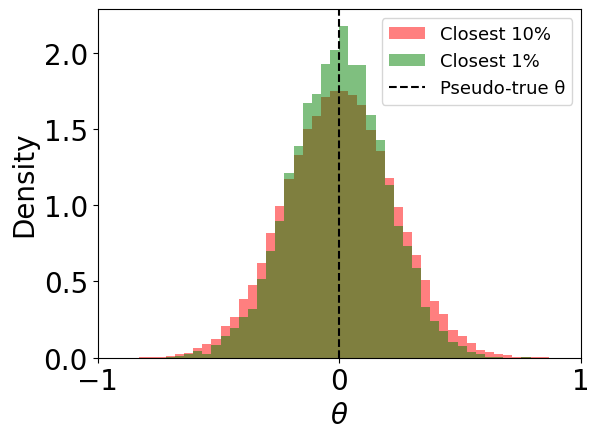

In [24]:
_, bins, _ = plt.hist(t1_eps10, density=True, bins=50, alpha=0.5, label='Closest 10%', color='red')
plt.hist(np.repeat(t1_eps01, 10), density=True, bins=bins, alpha=0.5,  label='Closest 1%', color='green')
plt.axvline(x=0, color='black', linestyle='--', label='Pseudo-true θ')

plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.xticks([-1, 0, 1])
plt.xlim(-1, 1)
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig("figs/fig1b.pdf")


In [5]:
import pickle as pkl

with open("t1_eps01_abc.pkl", "wb") as f:
    pkl.dump(t1_eps01, f)